# Problem: Detecting fraudulent app usage data with STL and confidence intervals
You are given app usage data, tracking the daily active users. You want to determine anomlies that are indicative of any suspicious activity, such as bots.

We will use Seasonal Trend Decomposition (STL)  decomposition and combine it with statistical methods to detect anomalies in time-series data.  




This code imports essential Python libraries for data analysis, visualization, and time series decomposition:

STL from statsmodels.tsa.seasonal is used for for Seasonal-Trend decomposition of time series data.








In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from cycler import cycler
from statsmodels.tsa.seasonal import STL

In the next cell, load the dataset from the file and display its contents to examine the data structure.


In [3]:
# Load the data
df = pd.read_csv('product_usage_data.csv')

# Display the first few rows
print(df.head())


  timestamp  daily_active_users
0  1/1/2024                1107
1  1/2/2024                1113
2  1/3/2024                1143
3  1/4/2024                1140
4  1/5/2024                1136


Following code converts the 'timestamp' column in the DataFrame df to a datetime format using pandas.to_datetime(), ensuring that the values are recognized as datetime objects for easier time-based operations and analysis


In [4]:
df['timestamp'] = pd.to_datetime(df['timestamp'])


Use the following code to display the first few rows of the updated DataFrame and verify the modifications:


In [5]:
print(df.head())

   timestamp  daily_active_users
0 2024-01-01                1107
1 2024-01-02                1113
2 2024-01-03                1143
3 2024-01-04                1140
4 2024-01-05                1136


Following  code creates a pandas Series named dau using the values from the 'daily_active_users' column of the DataFrame df, setting the 'timestamp' column as the index to enable time series operations.


In [6]:
dau = pd.Series(data=df['daily_active_users'].values, index=df['timestamp'])


In the next cell, plot the dau data using the Matplotlib library. Ensure that the plot includes appropriate labels for the x-axis and y-axis, as well as a suitable title.



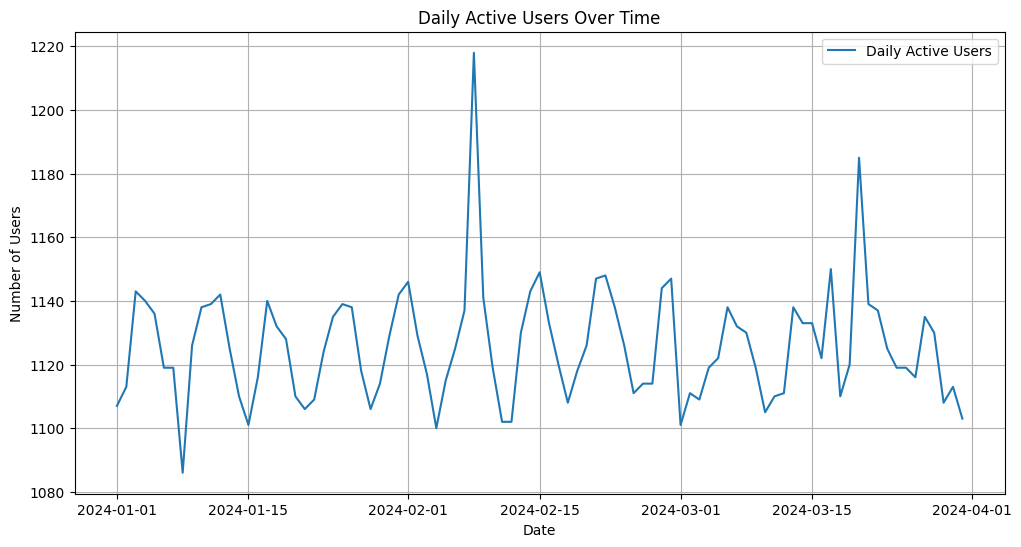

In [7]:
plt.figure(figsize=(12, 6))
plt.plot(dau, label='Daily Active Users')
plt.xlabel('Date')
plt.ylabel('Number of Users')
plt.title('Daily Active Users Over Time')
plt.legend()
plt.grid(True)
plt.show()


The code dau.describe() is calling the .describe() method on a DataFrame named dau.



In [8]:
dau.describe()


count      91.000000
mean     1125.703297
std        18.362700
min      1086.000000
25%      1113.000000
50%      1125.000000
75%      1138.000000
max      1218.000000
dtype: float64

Folloiwng code decomposes the time series data dau into trend, seasonal, and residual components using the STL method, specifying weekly seasonality (period=7), and stores the results in res.


In [9]:
stl = STL(dau, period=7)  # weekly seasonality
res = stl.fit()



In the following cell, print the different time series components.

In [10]:
print(res.seasonal)   # Seasonal component
print(res.trend)      # Trend component
print(res.resid)      # Residual component (anomalies/noise)

timestamp
2024-01-01   -29.112699
2024-01-02    -9.007788
2024-01-03    16.681902
2024-01-04    10.810216
2024-01-05    13.981569
                ...    
2024-03-27    26.987993
2024-03-28     6.704833
2024-03-29    -0.830159
2024-03-30    -1.994414
2024-03-31    -2.578938
Name: season, Length: 91, dtype: float64
timestamp
2024-01-01    1128.320578
2024-01-02    1127.468131
2024-01-03    1126.682798
2024-01-04    1125.964042
2024-01-05    1125.315609
                 ...     
2024-03-27    1119.600989
2024-03-28    1116.557829
2024-03-29    1113.511075
2024-03-30    1110.462253
2024-03-31    1107.416218
Name: trend, Length: 91, dtype: float64
timestamp
2024-01-01     7.792122
2024-01-02    -5.460343
2024-01-03    -0.364701
2024-01-04     3.225742
2024-01-05    -3.297178
                ...    
2024-03-27   -11.588982
2024-03-28     6.737338
2024-03-29    -4.680917
2024-03-30     4.532161
2024-03-31    -1.837280
Name: resid, Length: 91, dtype: float64


Following code, creates the plot of various time series components like, trend, seasonality, and residual.

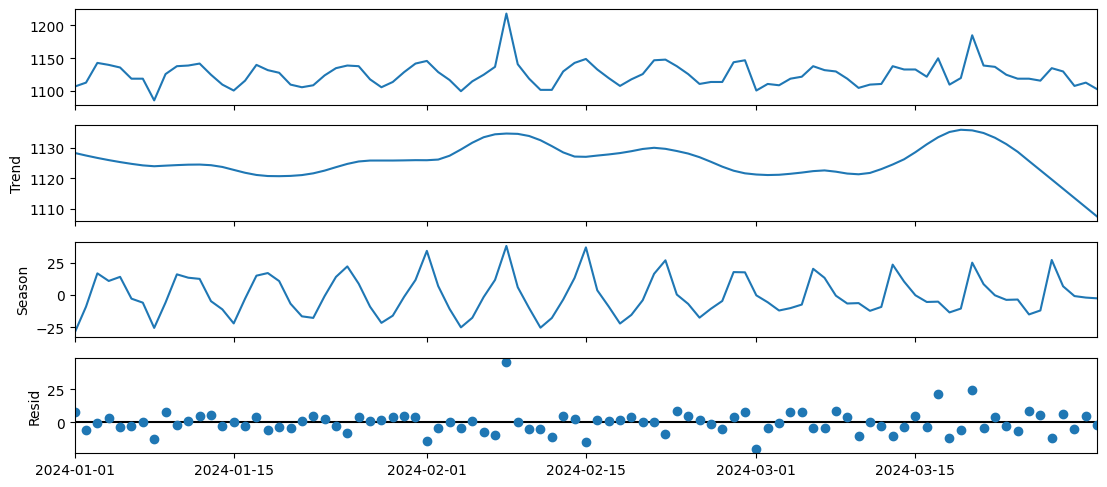

In [11]:
#plot 4 components, original, residual, trend, and noise using matplotlib

fig = res.plot()
fig.set_size_inches(12, 5)
plt.show()

Following code is used for minor anomaly detection by defining an upper and lower threshold around the trend component of the time series. These thresholds, trend_iv_l_minor and trend_iv_u_minor, are set by adjusting the trend with the mean and standard deviation of the residuals. Values outside this range can be considered anomalies, as they deviate significantly from the expected trend behavior.

In [12]:
trend_iv_l_minor = pd.Series(data=res.trend.values-np.mean(res.trend)-np.std(res.resid), index=res.trend.index)
trend_iv_u_minor = pd.Series(data=res.trend.values-np.mean(res.trend)+np.std(res.resid), index=res.trend.index)\

minor_anom = np.where((res.resid < trend_iv_l_minor) | (res.resid > trend_iv_u_minor), res.resid, np.nan)


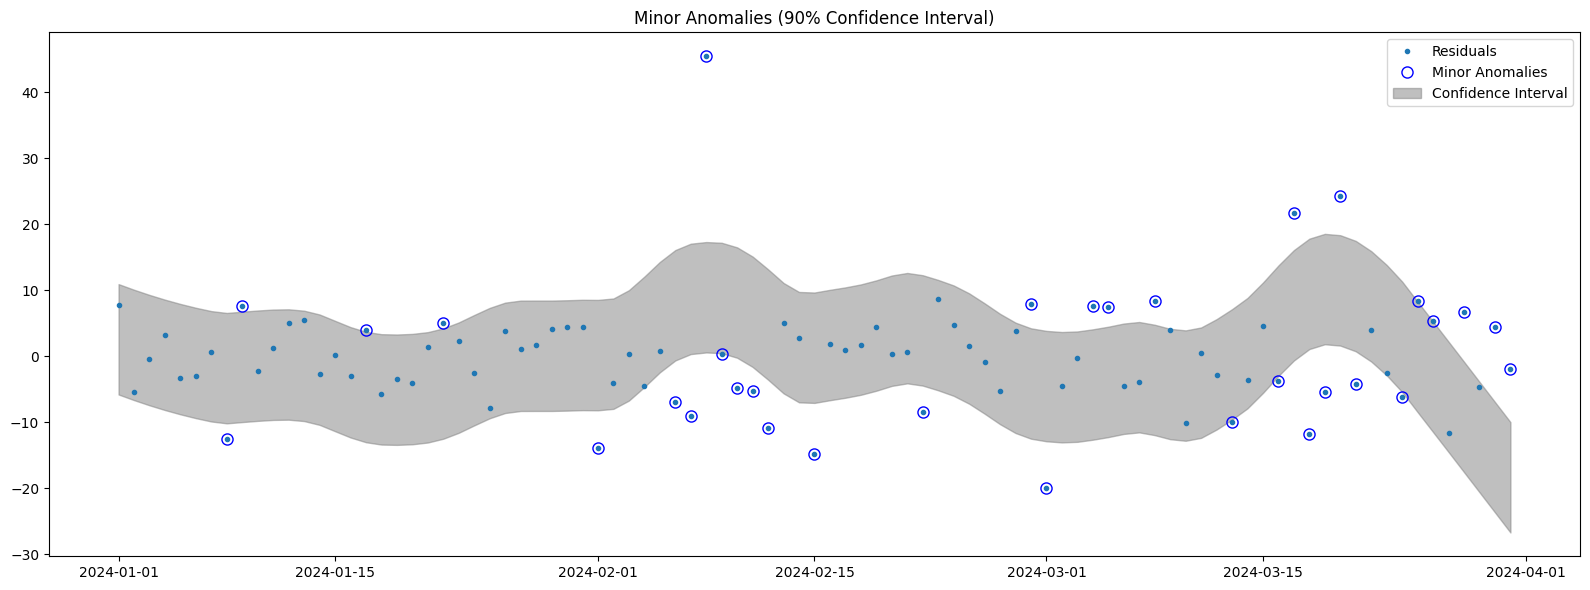

In [13]:
import matplotlib.pyplot as plt
import pandas as pd


# Create a single figure with one axis (ax)
fig, ax = plt.subplots(figsize=(16, 6))
# Plot the residuals
ax.plot(res.resid, marker='.', linestyle='none', label='Residuals')
# Plot the minor anomalies (blue circles)
ax.plot(pd.Series(minor_anom, res.resid.index), marker='o', linestyle='none', label='Minor Anomalies', color='blue', fillstyle='none', markersize=8)
# Fill the confidence interval (grey shaded area)
ax.fill_between(res.resid.index, trend_iv_l_minor, trend_iv_u_minor, color='grey', alpha=0.5, label='Confidence Interval')
# Set the title and labels
ax.set_title('Minor Anomalies (90% Confidence Interval)')
# Add a legend
ax.legend()
# Display the plot
plt.tight_layout()
plt.show()



Bsed on the above code, write Python code to find anomalies that are 2 times and 3 times away from standard deviation. Use trend component for detecting anomalies.

In [14]:
# Find anomalies at 2 standard deviations
trend_2sigma_lower = pd.Series(res.trend.values - 2 * np.std(res.resid), index=res.trend.index)
trend_2sigma_upper = pd.Series(res.trend.values + 2 * np.std(res.resid), index=res.trend.index)

anomalies_2sigma = np.where((res.resid < trend_2sigma_lower) | (res.resid > trend_2sigma_upper), res.resid, np.nan)


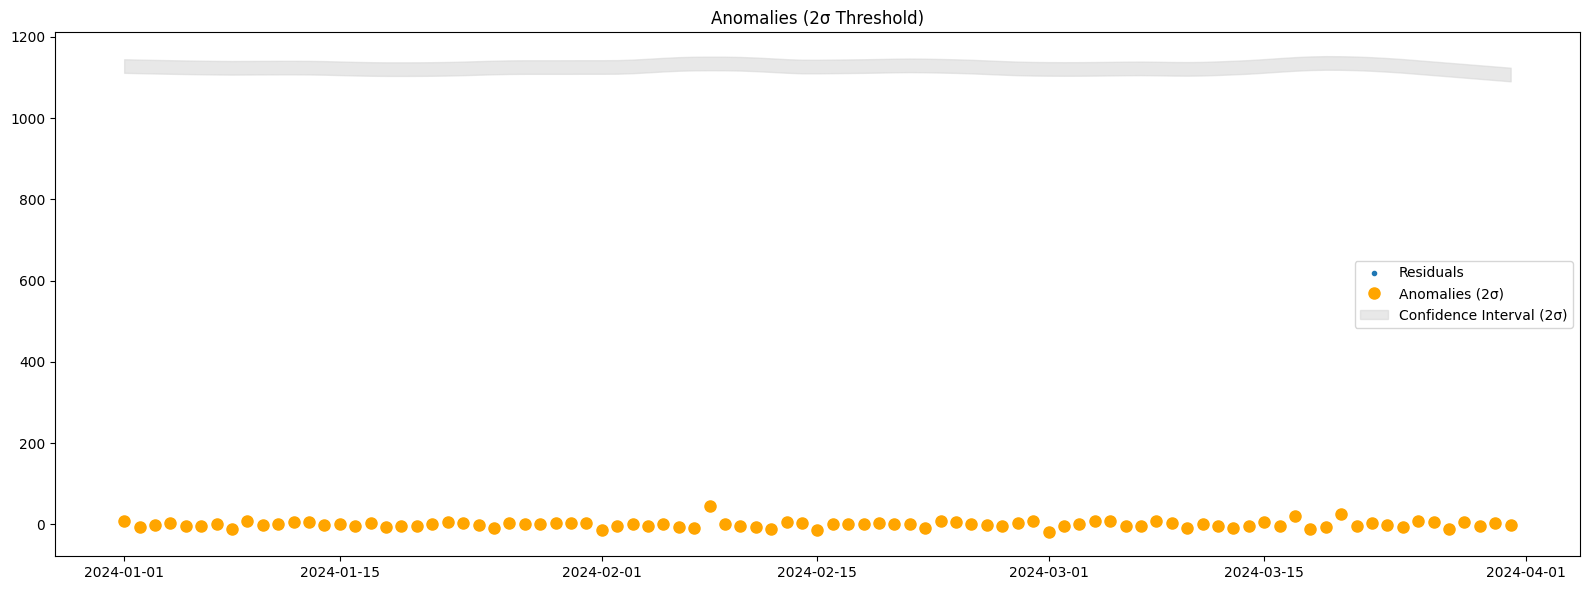

In [15]:
# Plot residuals with 2σ anomalies
fig, ax = plt.subplots(figsize=(16, 6))
ax.plot(res.resid, marker='.', linestyle='none', label='Residuals')
ax.plot(pd.Series(anomalies_2sigma, index=res.resid.index), marker='o', linestyle='none',
        label='Anomalies (2σ)', color='orange', markersize=8)
ax.fill_between(res.resid.index, trend_2sigma_lower, trend_2sigma_upper, color='lightgrey', alpha=0.5,
                label='Confidence Interval (2σ)')
ax.set_title('Anomalies (2σ Threshold)')
ax.legend()
plt.tight_layout()
plt.show()


In [16]:
# Find anomalies at 3 standard deviations
trend_3sigma_lower = pd.Series(res.trend.values - 3 * np.std(res.resid), index=res.trend.index)
trend_3sigma_upper = pd.Series(res.trend.values + 3 * np.std(res.resid), index=res.trend.index)

anomalies_3sigma = np.where((res.resid < trend_3sigma_lower) | (res.resid > trend_3sigma_upper), res.resid, np.nan)


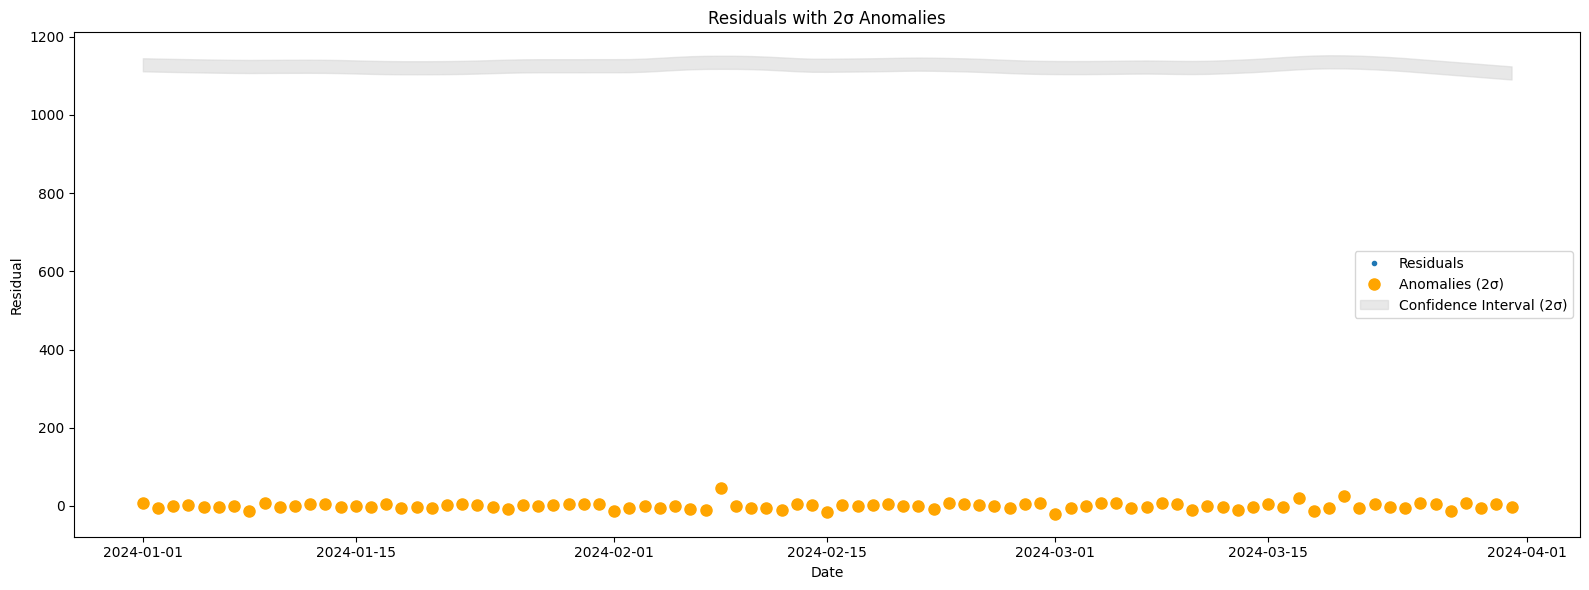

In [17]:
# Plot residuals and 2σ anomalies
fig, ax = plt.subplots(figsize=(16, 6))

# Residuals
ax.plot(res.resid, marker='.', linestyle='none', label='Residuals')

# Anomalies (assume you've already calculated anomalies_2sigma)
ax.plot(pd.Series(anomalies_2sigma, index=res.resid.index), 
        marker='o', linestyle='none', color='orange', label='Anomalies (2σ)', markersize=8)

# Confidence interval shading
ax.fill_between(res.resid.index, trend_2sigma_lower, trend_2sigma_upper, 
                color='lightgrey', alpha=0.5, label='Confidence Interval (2σ)')

# Title and labels
ax.set_title('Residuals with 2σ Anomalies')
ax.set_xlabel('Date')
ax.set_ylabel('Residual')
ax.legend()
plt.tight_layout()
plt.show()


Using a similar approach, write Python code to detect anomalies using the Z-score method. Apply 2-3 threshold values to detect anomalies, using the residual component for detection. Note that the formula for the Z-score is:
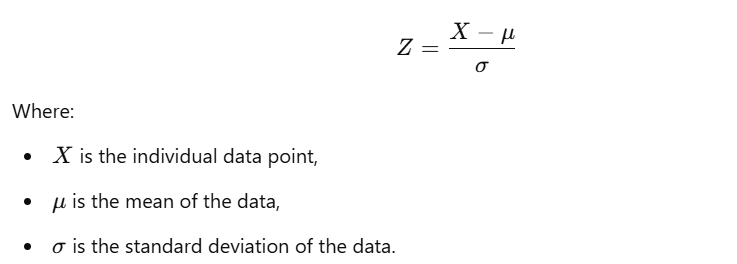

A point x is anomaly if Z-score for that point is greater than threshold.


In [18]:
# Calculate Z-scores for the residuals
residuals = res.resid
mean_resid = np.mean(residuals)
std_resid = np.std(residuals)
z_scores = (residuals - mean_resid) / std_resid

# Set different thresholds
thresholds = [2, 2.5, 3]

# Create a dictionary to store anomalies for each threshold
z_anomalies = {}
for threshold in thresholds:
    z_anomalies[threshold] = np.where(np.abs(z_scores) > threshold, residuals, np.nan)


#Important: Lab Logbook Requirement:
#Plot the anomalies in next cell and include this graph in your lab logbook."

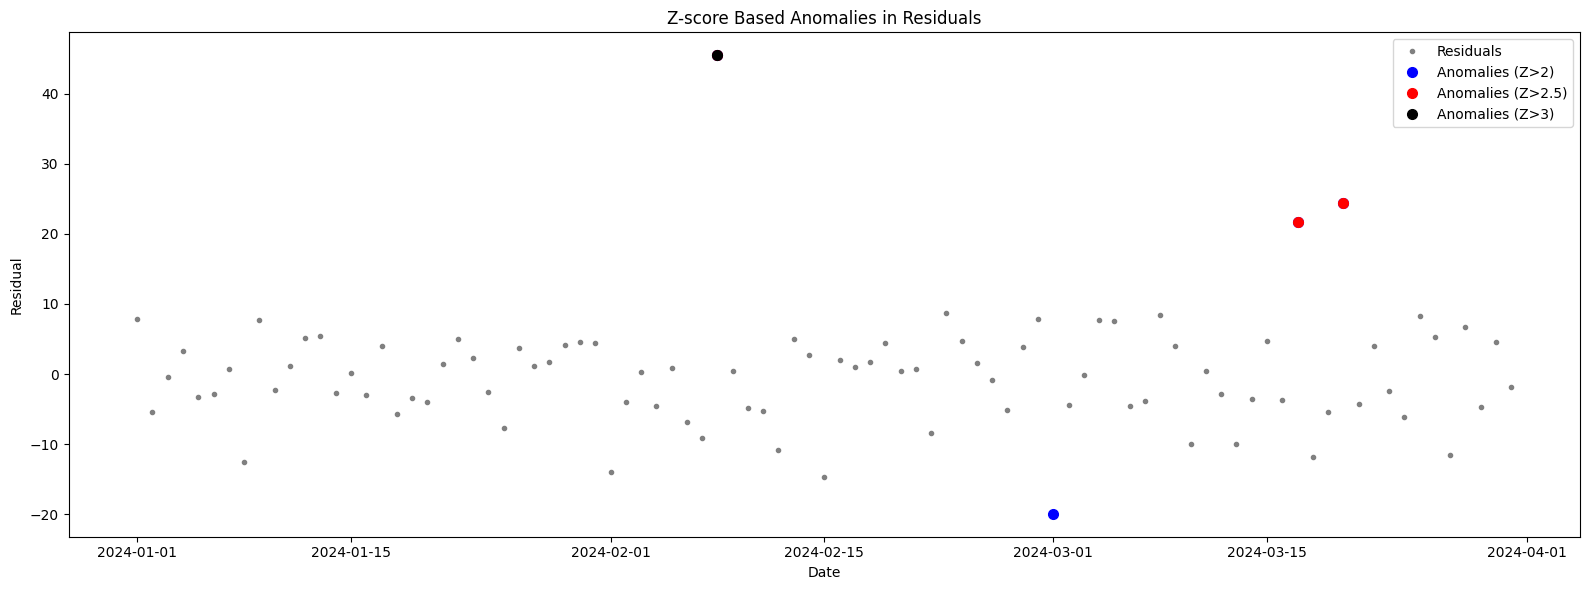

In [22]:
# Plotting anomalies for 2, 2.5, and 3 Z-score thresholds
fig, ax = plt.subplots(figsize=(16, 6))

# Plot residuals
ax.plot(residuals, label='Residuals', marker='.', linestyle='none', color='gray')

# Overlay anomalies
colors = ['blue', 'red', 'black']
for i, threshold in enumerate(thresholds):
    ax.plot(pd.Series(z_anomalies[threshold], index=residuals.index),
            marker='o', linestyle='none', label=f'Anomalies (Z>{threshold})',
            color=colors[i], markersize=7)

# Title and legend
ax.set_title('Z-score Based Anomalies in Residuals')
ax.set_xlabel('Date')
ax.set_ylabel('Residual')
ax.legend()
plt.tight_layout()
plt.show()


Using a similar approach, write Python code to detect anomalies using the IQR method. Apply 2-3 threshold values to detect anomalies, using the residual component for detection. Note that the formula for the IQR is:

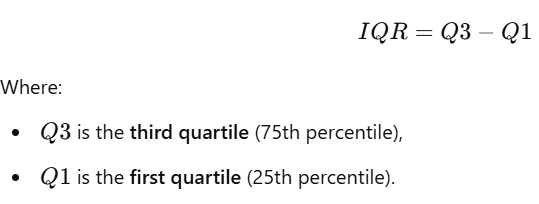

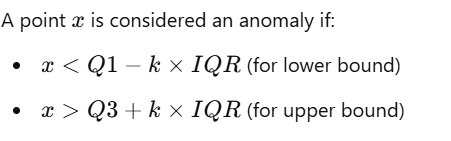

In [20]:
# Calculate IQR for residuals
Q1 = np.percentile(res.resid, 25)
Q3 = np.percentile(res.resid, 75)
IQR = Q3 - Q1

# Try different k values
k_values = [1.5, 2, 2.5]

# Store anomalies for each k
iqr_anomalies = {}
for k in k_values:
    lower_bound = Q1 - k * IQR
    upper_bound = Q3 + k * IQR
    iqr_anomalies[k] = np.where((res.resid < lower_bound) | (res.resid > upper_bound), res.resid, np.nan)


#Important: Lab Logbook Requirement:
#Plot the anomalies in next cell and include this graph in your lab logbook."

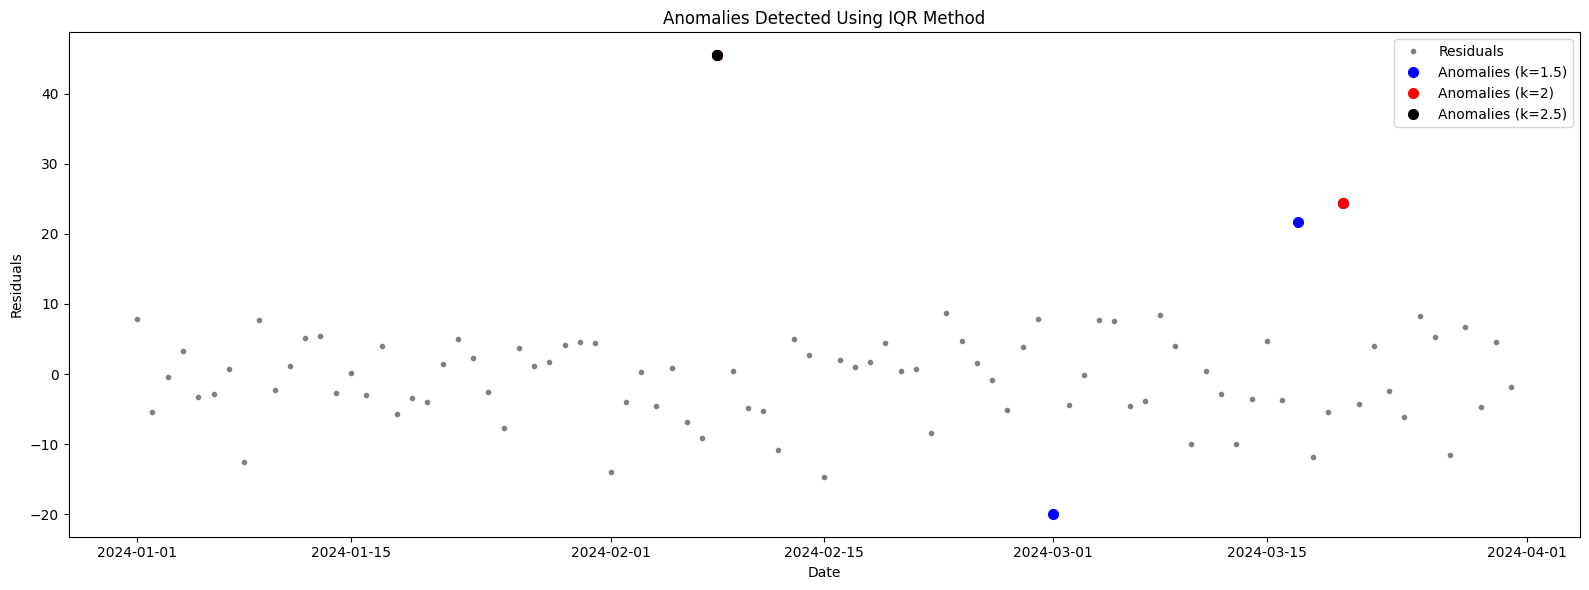

In [21]:
# Plot original series and anomalies for each k
fig, ax = plt.subplots(figsize=(16, 6))

# Plot original residuals
ax.plot(res.resid, marker='.', linestyle='none', color='gray', label='Residuals')

# Colors for different k
colors = ['blue', 'red', 'black']

# Plot anomalies for each k value
for i, k in enumerate(k_values):
    ax.plot(pd.Series(iqr_anomalies[k], index=res.resid.index),
            marker='o', linestyle='none', label=f'Anomalies (k={k})',
            color=colors[i], markersize=7)

# Add labels and legend
ax.set_title('Anomalies Detected Using IQR Method')
ax.set_xlabel('Date')
ax.set_ylabel('Residuals')
ax.legend()
plt.tight_layout()
plt.show()


## Folooing section is optional for this lab.

The code below uses Linear Regression. Based on the following code write your own code to detect anomalies in using ARIMA which is also one of the regression algorithm.

ARIMA is a model used to predict future value in a time series.
It looks at past data to find patterns and trends.

AR (AutoRegressive): Uses past values to predict future ones.
I (Integrated): Makes the data more stable by removing trends.
MA (Moving Average): Uses past errors (differences between actual and predicted values) to improve predictions.

You can use the Python library statsmodels.tsa.arima.model to implement ARIMA.
https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima.model.ARIMA.html

You need to compare the ARIMA prediction and actual values and if they are significantly different then the points can be considered as anomolous.







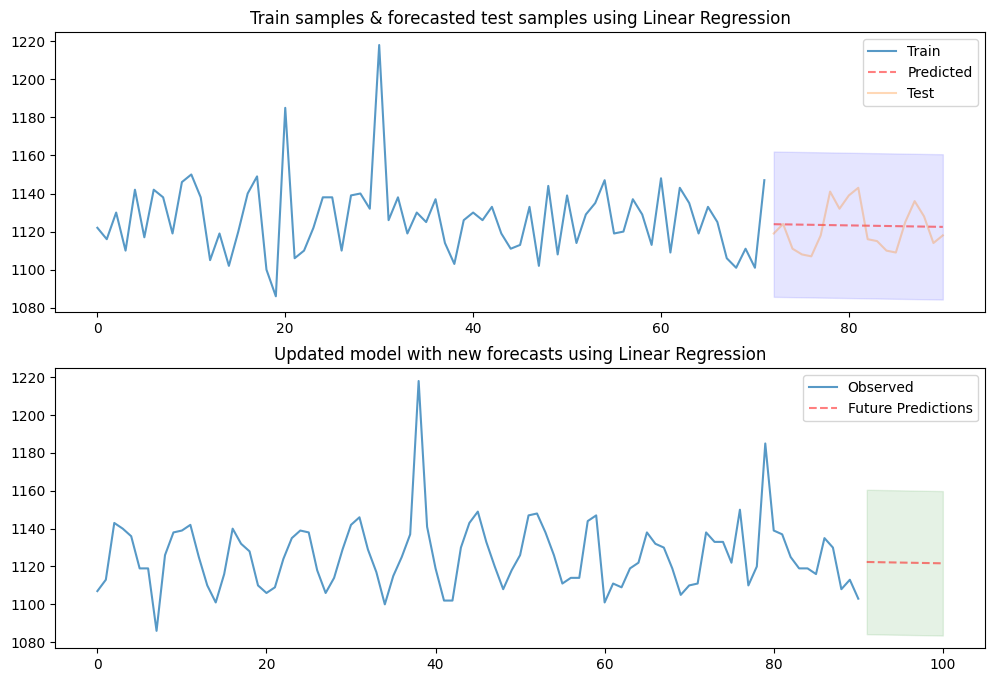

MSE for Linear Regression Forecast: 133.6046


In [21]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

# Splitting data into train and test
train, test = train_test_split(dau.values, train_size=0.8, random_state=42)

# Creating time indices as features for regression
train_indices = np.arange(len(train)).reshape(-1, 1)
test_indices = np.arange(len(train), len(train) + len(test)).reshape(-1, 1)

# Training linear regression model
model = LinearRegression()
model.fit(train_indices, train)

# Making predictions
preds = model.predict(test_indices)

# Calculating confidence intervals (assuming normal distribution of residuals)
residuals = train - model.predict(train_indices)
std_dev = np.std(residuals)
conf_int = np.column_stack((preds - 1.96 * std_dev, preds + 1.96 * std_dev))

# Plotting results
fig, axes = plt.subplots(2, 1, figsize=(12, 8))
x_axis = np.arange(len(train) + len(test))
axes[0].plot(x_axis[:len(train)], train, alpha=0.75, label="Train")
axes[0].plot(x_axis[len(train):], preds, alpha=0.5, linestyle='--', color='r', label="Predicted")
axes[0].plot(x_axis[len(train):], test, alpha=0.3, label="Test")
axes[0].fill_between(x_axis[len(train):], conf_int[:, 0], conf_int[:, 1], alpha=0.1, color='b')
axes[0].set_title("Train samples & forecasted test samples using Linear Regression")
axes[0].legend()

# Detecting anomalies
anomalies = (test < conf_int[:, 0]) | (test > conf_int[:, 1])
axes[0].scatter(x_axis[len(train):][anomalies], test[anomalies], color='red', label="Anomalies")

# Updating model with test data and predicting future values
new_indices = np.arange(len(dau.values), len(dau.values) + 10).reshape(-1, 1)
new_preds = model.predict(new_indices)
new_conf_int = np.column_stack((new_preds - 1.96 * std_dev, new_preds + 1.96 * std_dev))

axes[1].plot(np.arange(len(dau.values)), dau, alpha=0.75, label="Observed")
axes[1].plot(new_indices, new_preds, alpha=0.5, linestyle='--', color='r', label="Future Predictions")
axes[1].fill_between(new_indices.flatten(), new_conf_int[:, 0], new_conf_int[:, 1], alpha=0.1, color='g')
axes[1].set_title("Updated model with new forecasts using Linear Regression")
axes[1].legend()
plt.show()

# Compute MSE
mse_linear = mean_squared_error(test, preds)
print(f"MSE for Linear Regression Forecast: {mse_linear:.4f}")